- U-Net 

In [243]:
import segmentation_models
from segmentation_models import Unet
from segmentation_models import backbones 
#import get_preprocessing
import pandas as pd
import cv2

In [3]:
from PIL import Image
from tqdm import tqdm_notebook
import os

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
model = segmentation_models.Unet()

58892288/58889256 [==============================] - 42s 1us/step


In [171]:
def read_images(directory='./train/'):
    images = {}
    masks = {}
    filelist = list(os.listdir(directory))
    for file in tqdm_notebook(filelist):
        image = Image.open(f'{directory}{file}')
        image = image.resize(size=(224,224))
        img_array = np.asarray(image)
        if "_mask" not in file:
            images[file[:-4]] = img_array
        else:
            masks[file[:-9]] = img_array 
    return images, masks

def prepare_dataset(images, masks):
    X_dict = images
    Y_dict = masks
    indices_with_masks = X_dict.keys()
    X = [X_dict[key] for key in indices_with_masks]
    Y = [Y_dict.get(key, 0) for key in indices_with_masks]
    indices_with_masks_list = list(indices_with_masks)
    x = np.array([np.transpose([x, x, x]) for x in X])
    y = np.array([np.transpose([y]) / 255 for y in Y])
    return x, y

In [172]:
images, masks = read_images()

In [174]:
train_x, train_y = prepare_dataset(images, masks)

37_105


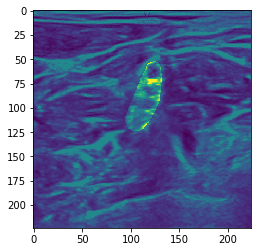

12_42


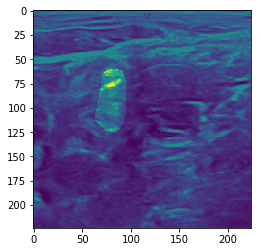

5_18


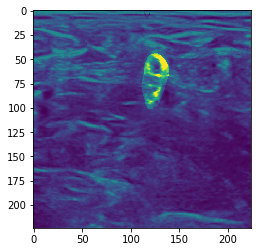

In [175]:
%matplotlib inline

for i, (x, y) in enumerate(zip(X[0:10], Y[0:10])):
    if np.max(y)>0:
        print(indices_with_masks_list[i])
        plt.imshow(x*(y / 255 + 0.9))
        plt.show()

In [194]:
train_keys = list(images.keys())

In [195]:
train_keys[0]

'18_101'

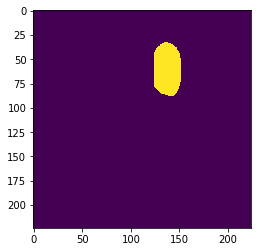

In [197]:
plt.imshow(masks[train_keys[1]])

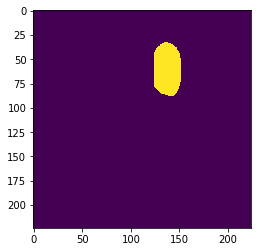

In [209]:
plt.imshow(train_y[1].reshape(224, 224).transpose())

In [204]:
preprocessing_fn = backbones.get_preprocessing('resnet34')
x = preprocessing_fn(x)

In [ ]:
# prepare model
model = Unet(backbone_name='resnet34', encoder_weights='imagenet')
model.compile('Adam', 'binary_crossentropy', ['binary_accuracy'])

In [ ]:
# train model
model.fit(x, y, validation_split=0.3, epochs=10)

Train on 3944 samples, validate on 1691 samples
Epoch 1/10
3944/3944 [==============================] - 719s 182ms/step - loss: 0.0310 - binary_accuracy: 0.9909 - val_loss: 0.0492 - val_binary_accuracy: 0.9788
Epoch 2/10
3944/3944 [==============================] - 715s 181ms/step - loss: 0.0238 - binary_accuracy: 0.9918 - val_loss: 0.0399 - val_binary_accuracy: 0.9837
Epoch 3/10
 992/3944 [======>.......................] - ETA: 7:27 - loss: 0.0194 - binary_accuracy: 0.9931

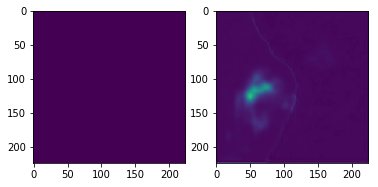

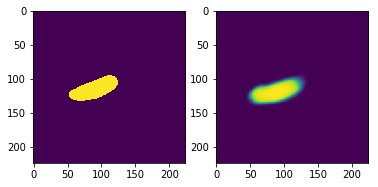

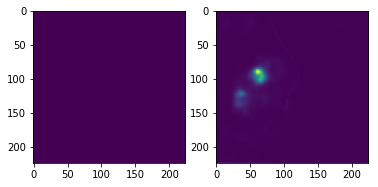

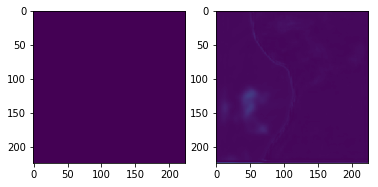

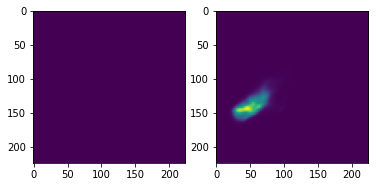

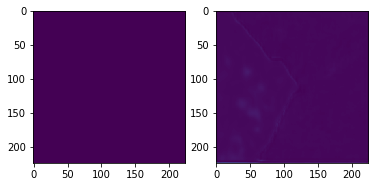

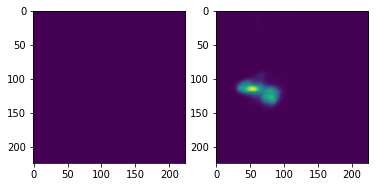

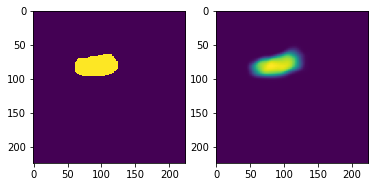

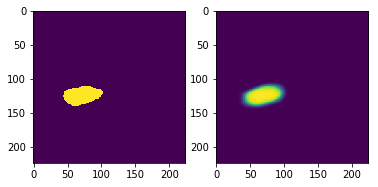

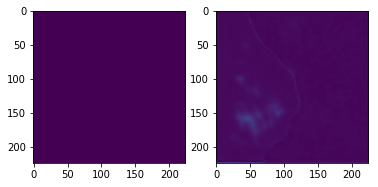

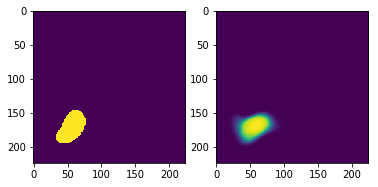

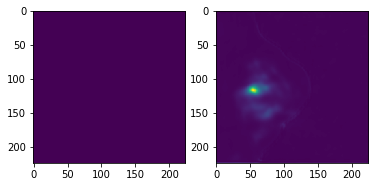

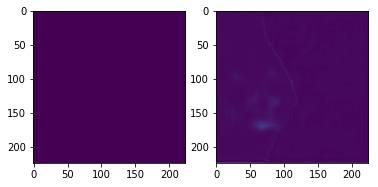

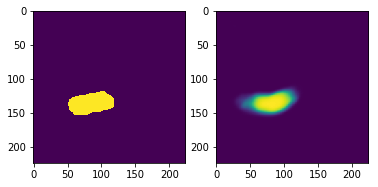

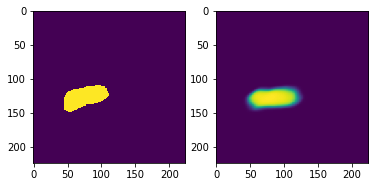

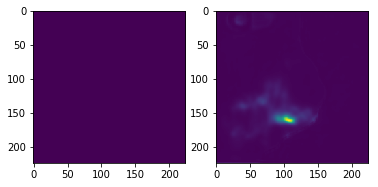

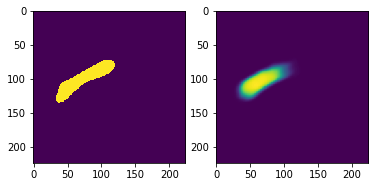

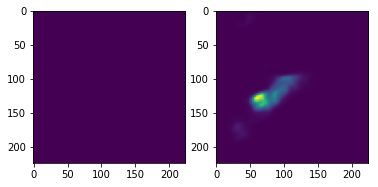

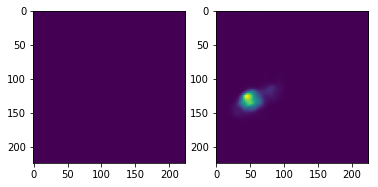

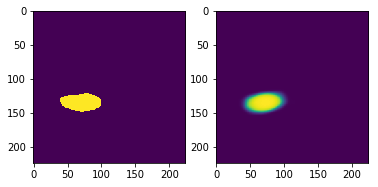

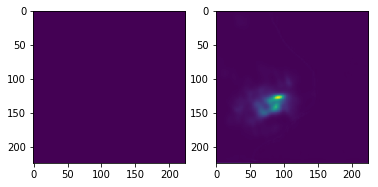

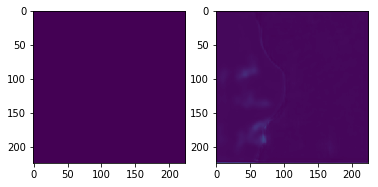

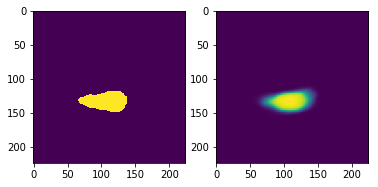

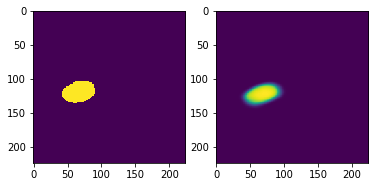

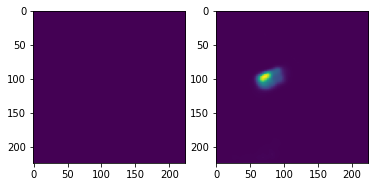

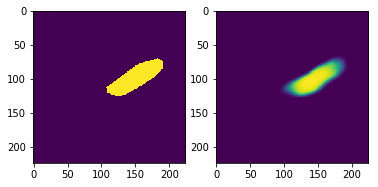

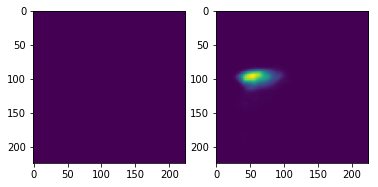

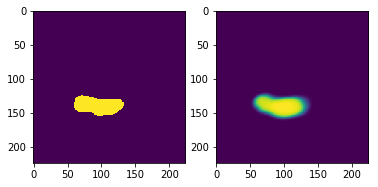

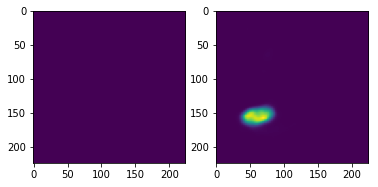

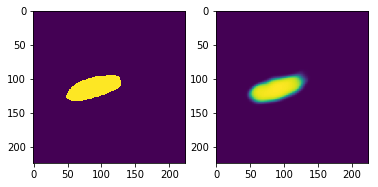

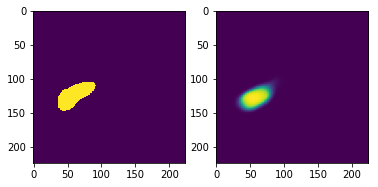

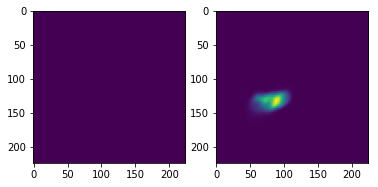

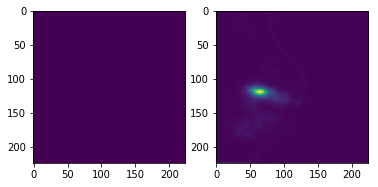

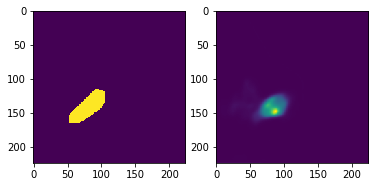

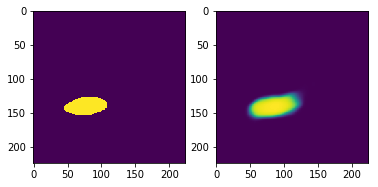

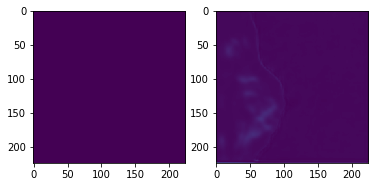

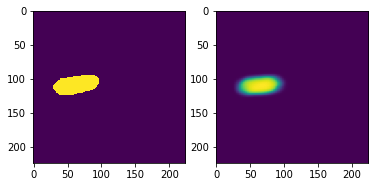

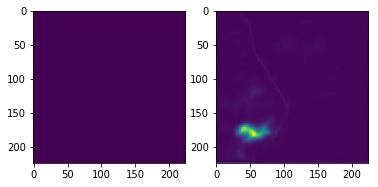

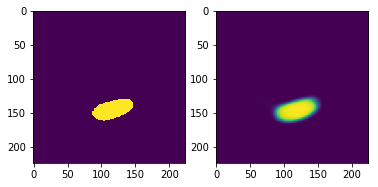

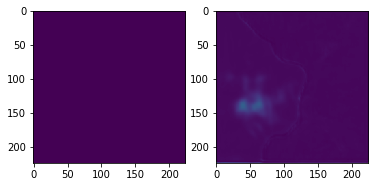

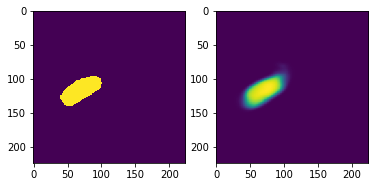

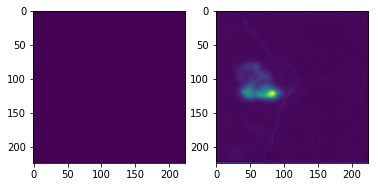

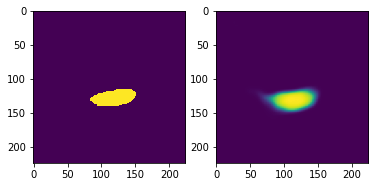

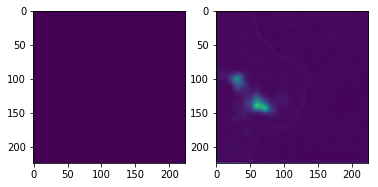

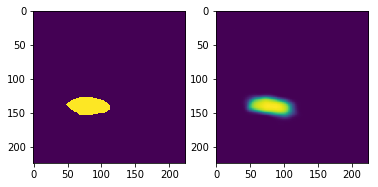

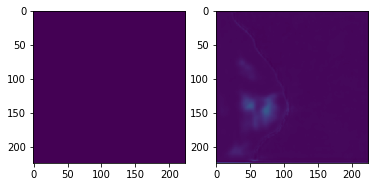

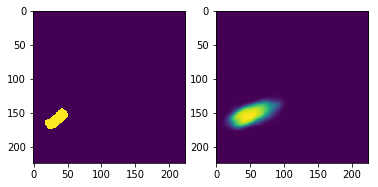

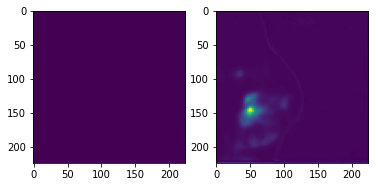

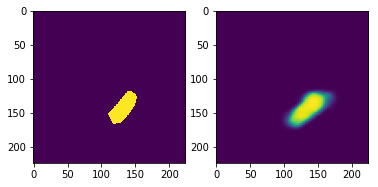

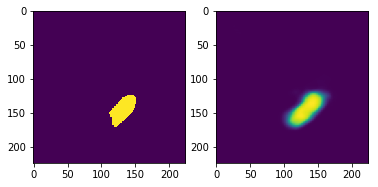

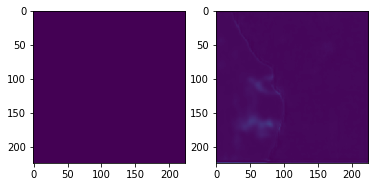

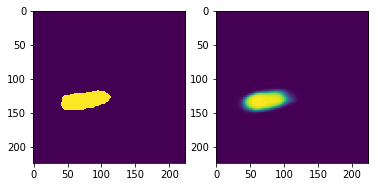

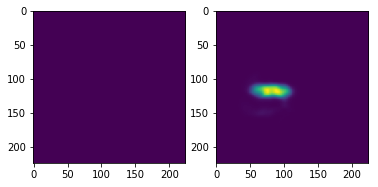

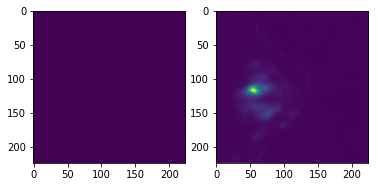

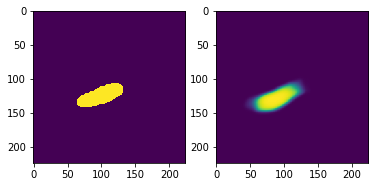

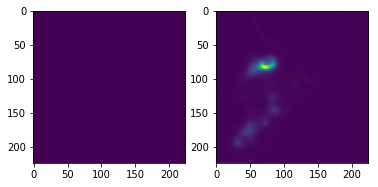

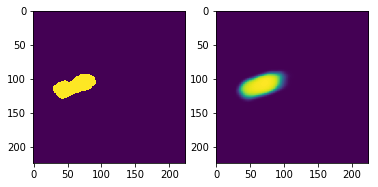

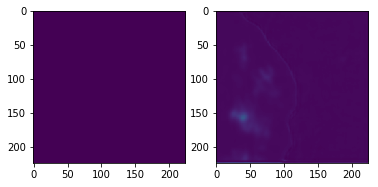

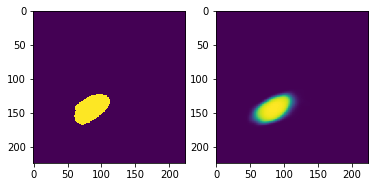

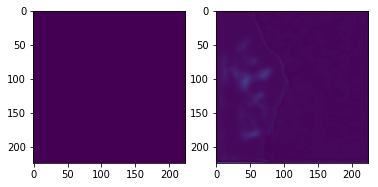

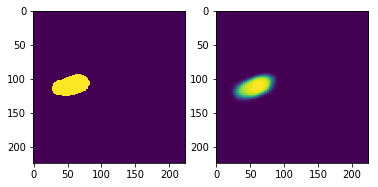

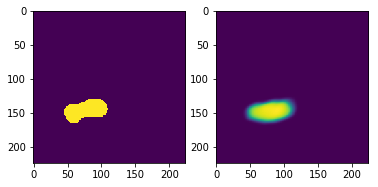

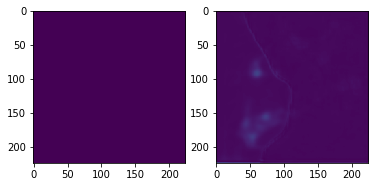

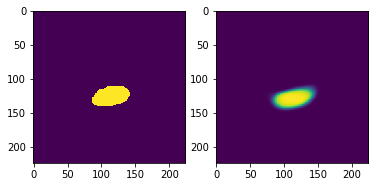

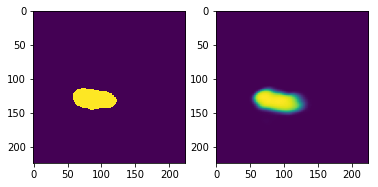

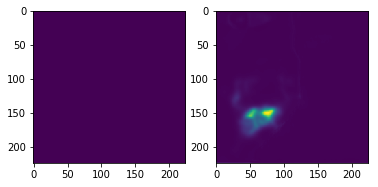

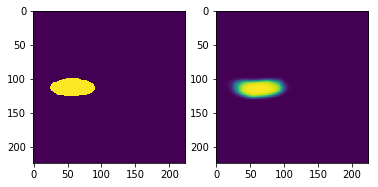

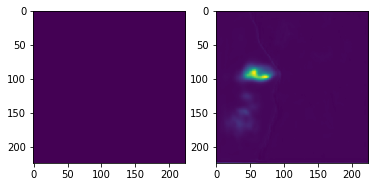

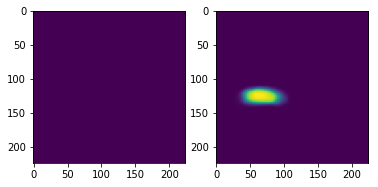

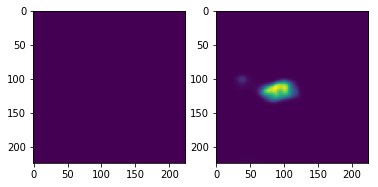

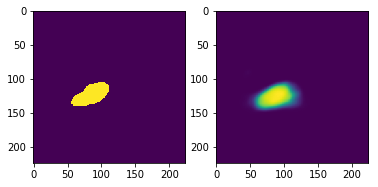

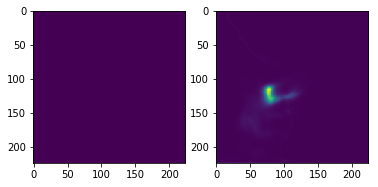

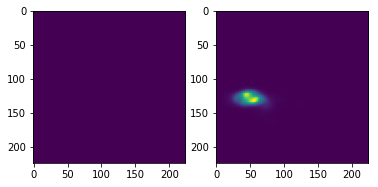

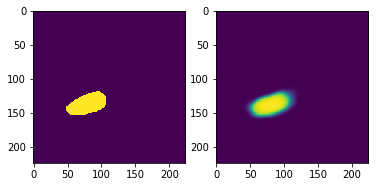

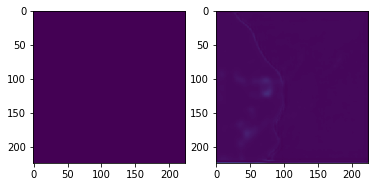

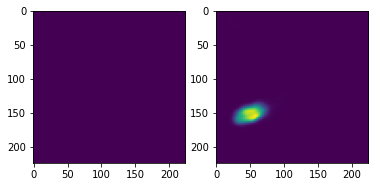

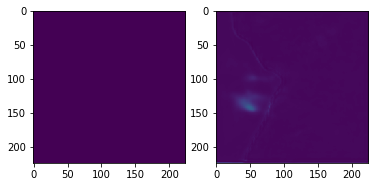

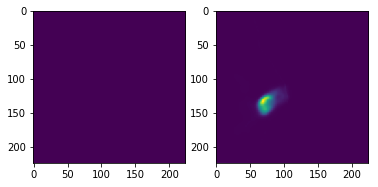

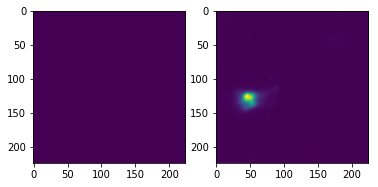

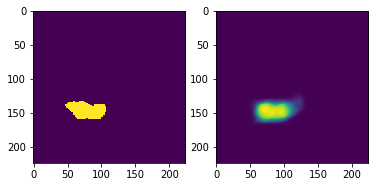

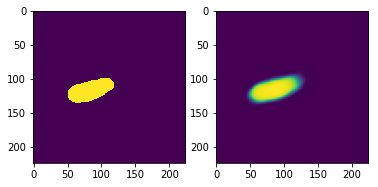

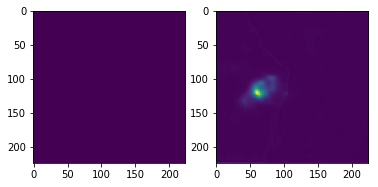

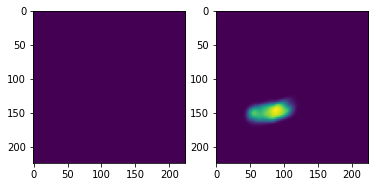

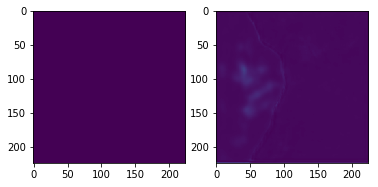

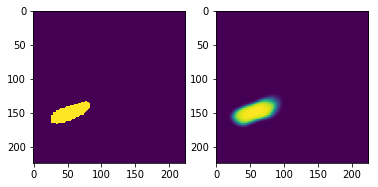

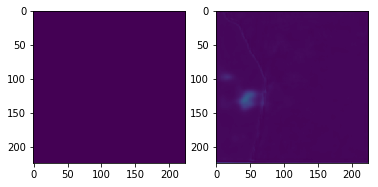

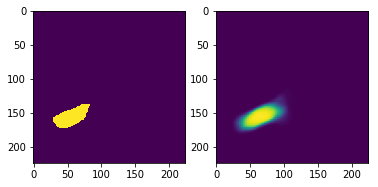

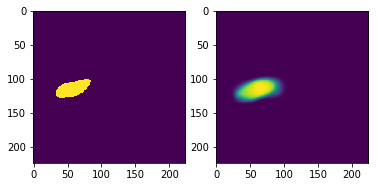

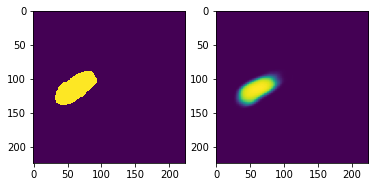

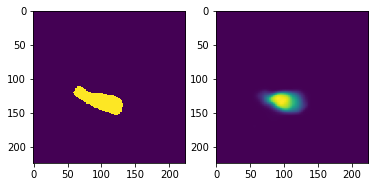

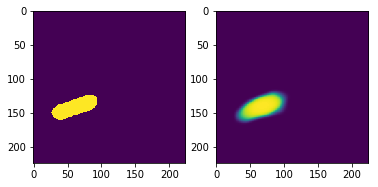

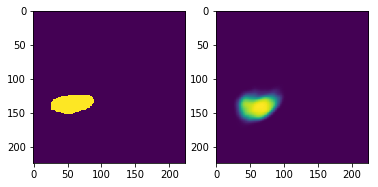

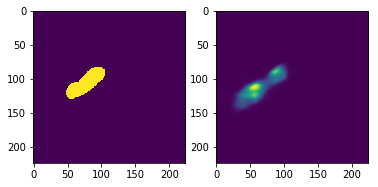

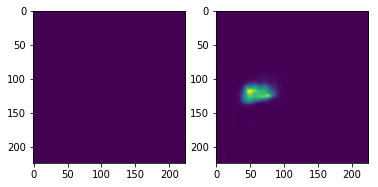

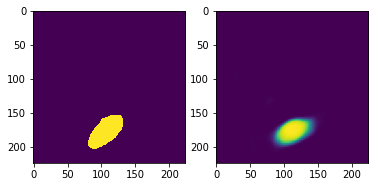

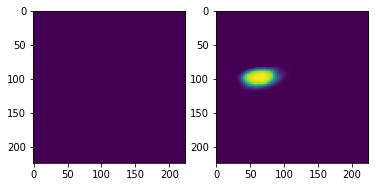

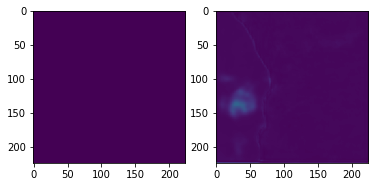

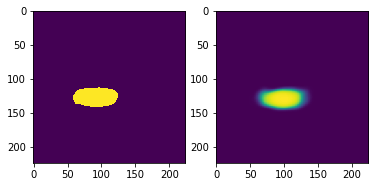

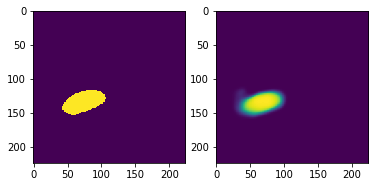

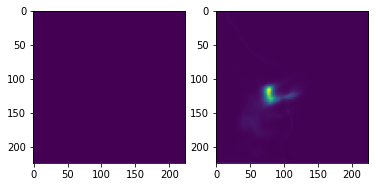

In [66]:
for i in range(0,100):
    prediction = model.predict(x[i:i+1])[0].reshape(224, 224)
    mask = y[i].reshape(224, 224)
    image = x[i].transpose()[0].transpose()
#     if np.max(mask) > 0:
    plt.subplot(121)
    plt.imshow(mask)
    plt.subplot(122)
    plt.imshow(prediction > 0)
    plt.show()

In [210]:
test_images, test_masks = read_images("./test/")

In [211]:
test_x, test_y = prepare_dataset(test_images, test_masks)

In [212]:
test_x = preprocessing_fn(test_x)

In [213]:
masks = model.predict(test_x)

In [106]:
model.save_weights("test_weights.h5")
model.save("test.h5")

In [247]:
shape_to_scale = np.asarray(Image.open(f'./test/148.tif')).transpose().shape
shape_to_scale

(580, 420)

In [248]:
def scale(image, interpolation=cv2.INTER_CUBIC):
    return cv2.resize(image, dsize=shape_to_scale, interpolation=interpolation)

INTER_NEAREST - a nearest-neighbor interpolation
INTER_LINEAR - a bilinear interpolation (used by default)
INTER_AREA - resampling using pixel area relation. It may be a preferred method for image decimation, as it gives moire’-free results. But when the image is zoomed, it is similar to the INTER_NEAREST method.
INTER_CUBIC - a bicubic interpolation over 4x4 pixel neighborhood
INTER_LANCZOS4 - a Lanczos interpolation over 8x8 pixel neighborhood

In [249]:
masks[0].reshape(224, 224).transpose().shape

(224, 224)

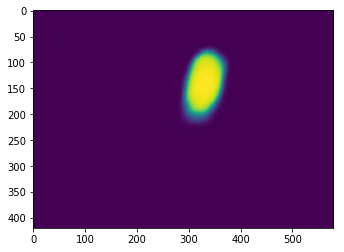

In [250]:
plt.imshow(scale(masks[0].reshape(224, 224).transpose(), cv2.INTER_CUBIC))
plt.show()
# plt.imshow(scale(masks[0].transpose(), cv2.INTER_NEAREST))
# plt.show()
# plt.imshow(scale(masks[0].transpose(), cv2.INTER_LINEAR))
# plt.show()
# plt.imshow(scale(masks[0].transpose(), cv2.INTER_AREA))
# plt.show()
# plt.imshow(scale(masks[0].transpose(), cv2.INTER_LANCZOS4))

In [ ]:
scaled_masks = [scale(mask.reshape(224, 224).transpose()) for mask in tqdm_notebook(masks)]

In [ ]:
for x, mask in zip(test_x[0:10], masks[0:10]):
    image = x.transpose()[0]
    plt.imshow(image * (mask.reshape(224, 224).transpose() + 0.7))
    plt.show()

In [ ]:
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

In [230]:
scaled_masks = [rle_encoding(mask > 0.5) for mask in tqdm_notebook(scaled_masks)]

In [231]:
" ".join([str(i) for i in scaled_masks[0]])

'123751 31 124318 51 124888 68 125462 79 126035 91 126607 102 127182 109 127755 118 128330 124 128905 130 129482 134 130058 139 130634 143 131211 147 131789 149 132367 152 132945 154 133523 156 134102 157 134680 159 135259 160 135838 161 136416 163 136996 162 137575 162 138154 163 138734 162 139314 161 139893 161 140473 160 141053 158 141633 157 142213 155 142793 153 143374 149 143954 146 144535 143 145116 140 145696 138 146278 133 146859 130 147440 126 148022 121 148604 115 149185 111 149767 105 150349 99 150931 92 151512 87 152096 76 152680 62 153264 46 153850 25'

In [232]:
images = list(test_images.keys())
string_masks = [" ".join([str(i) for i in mask]) for mask in tqdm_notebook(scaled_masks)]
string_masks = [mask or np.nan for mask in string_masks]

In [233]:
submission = pd.DataFrame()
submission["img"] = images
submission["pixels"] = string_masks
submission = submission.set_index("img")

In [242]:
submission.to_csv("our_submission.csv")

In [235]:
submission

,pixels
img,
3383,123751 31 124318 51 124888 68 125462 79 126035...
1404,124337 25 124901 48 125468 65 126038 81 126608...
2253,159637 18 160213 27 160789 35 161366 42 161944...
5065,NaN
1260,144054 10 144629 21 145204 31 145781 38 146357...
3947,NaN
1425,129535 22 130105 42 130678 56 131249 72 131824...
4084,111009 17 111583 28 112161 32 112738 38 113315...
1604,NaN
